In [5]:
import sys
sys.path.append('../src')
from causal_shapley import causal_shapley
%load_ext autoreload
%autoreload 2

import random
import warnings
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
import itertools
from itertools import combinations, permutations, chain

warnings.filterwarnings("ignore")
import networkx as nx
import matplotlib.pyplot as plt

from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete.CPD import TabularCPD

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Causal Shapley Pipeline

### Prepare bayesian network and dataset

In [6]:
G = nx.DiGraph()

G.add_nodes_from(["asia", "smoke", "tub", "lung", "bronc", "either", "xray", "dysp"])
edges = [
    # tuple of direction (from, to)
    ("asia", "tub"),
    ("smoke", "lung"),
    ("smoke", "bronc"),
    ("tub", "either"),
    ("lung", "either"),
    ("either", "xray"),
    ("either", "dysp"),
    ("bronc", "dysp"),
]
G.add_edges_from(edges)

# initiate BN
dataset = pd.read_csv('../data/asia10K.csv')
asia_bn = BayesianNetwork(edges)
asia_bn.fit(dataset)
asia_bn.get_cpds()

[<TabularCPD representing P(asia:2) at 0x1bbf65816d0>,
 <TabularCPD representing P(tub:2 | asia:2) at 0x1bbe5271ac0>,
 <TabularCPD representing P(smoke:2) at 0x1bbf77f67c0>,
 <TabularCPD representing P(lung:2 | smoke:2) at 0x1bbf77f6520>,
 <TabularCPD representing P(bronc:2 | smoke:2) at 0x1bbf77f6640>,
 <TabularCPD representing P(either:2 | lung:2, tub:2) at 0x1bbf77f65b0>,
 <TabularCPD representing P(xray:2 | either:2) at 0x1bbf77f6490>,
 <TabularCPD representing P(dysp:2 | bronc:2, either:2) at 0x1bbf650f0a0>]

### Estimate shapley value (method)

In [40]:
target = 'lung'
causal_shapley(dataset, asia_bn, G, target=target)

Shapley value estimation for data point [1119]:
smoke      no
lung       no
asia       no
tub        no
either     no
xray       no
bronc     yes
dysp       no
Name: 1119, dtype: object
Target: bronc

feature_of_interest:  smoke
Value: -0.1267634906616936

feature_of_interest:  lung
Value: 0.0

feature_of_interest:  asia
Value: 0.0

feature_of_interest:  tub
Value: 0.0

feature_of_interest:  either
Value: -0.11820967548869916

feature_of_interest:  xray
Value: 0.0

feature_of_interest:  dysp
Value: -0.12325196084842677
{'smoke': -0.1267634906616936, 'lung': 0.0, 'asia': 0.0, 'tub': 0.0, 'either': -0.11820967548869916, 'xray': 0.0, 'dysp': -0.12325196084842677}


{'smoke': -0.1267634906616936,
 'lung': 0.0,
 'asia': 0.0,
 'tub': 0.0,
 'either': -0.11820967548869916,
 'xray': 0.0,
 'dysp': -0.12325196084842677}

In [52]:
# len(dataset)
target = 'bronc'
shapley_values = {}
num_sample = 100
for i in range(len(dataset)):
    cs = causal_shapley(dataset, asia_bn, G, target=target, sample_idx=i)
    
    for col in cs:
        print(col, abs(cs[col]))
        shapley_values[col] = (abs(cs[col]) + shapley_values[col]) if col in shapley_values else abs(cs[col])
    # break
    if i == num_sample:
        break

Shapley value estimation for data point [0]:
smoke     yes
lung      yes
asia       no
tub        no
either    yes
xray      yes
bronc     yes
dysp      yes
Name: 0, dtype: object
Target: bronc

feature_of_interest:  smoke
Value: 0.1530129343895301

feature_of_interest:  lung
Value: 0.0

feature_of_interest:  asia
Value: 0.0

feature_of_interest:  tub
Value: 0.0

feature_of_interest:  either
Value: 0.030951990366119217

feature_of_interest:  xray
Value: 0.0

feature_of_interest:  dysp
Value: 0.038863247654523383
{'smoke': 0.1530129343895301, 'lung': 0.0, 'asia': 0.0, 'tub': 0.0, 'either': 0.030951990366119217, 'xray': 0.0, 'dysp': 0.038863247654523383}
smoke 0.1530129343895301
lung 0.0
asia 0.0
tub 0.0
either 0.030951990366119217
xray 0.0
dysp 0.038863247654523383
Shapley value estimation for data point [1]:
smoke      no
lung       no
asia       no
tub        no
either     no
xray      yes
bronc     yes
dysp      yes
Name: 1, dtype: object
Target: bronc

feature_of_interest:  smoke
Va

In [58]:
shapley_values

for key in shapley_values.keys():
    shapley_values[key] = shapley_values[key] / num_sample

NameError: name 'num_sample' is not defined

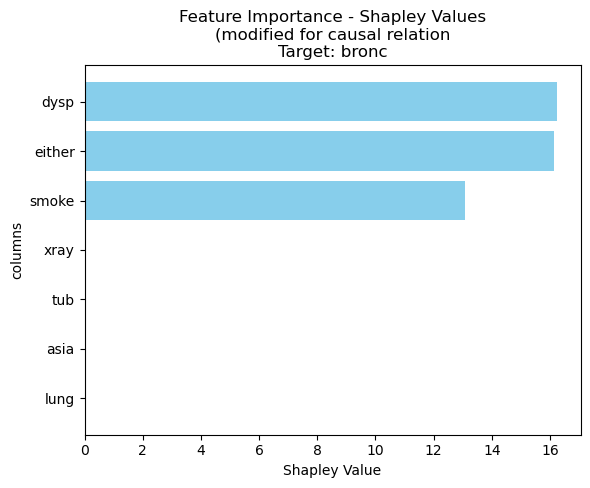

In [56]:
sorted_shapley_values = dict(sorted(shapley_values.items(), key=lambda item: item[1]))
# Creating the plot
fig, ax = plt.subplots()
ax.barh(list(sorted_shapley_values.keys()), list(sorted_shapley_values.values()), color='skyblue')
ax.set_xlabel('Shapley Value')
ax.set_ylabel('columns')
ax.set_title(f'Feature Importance - Shapley Values\n(modified for causal relation\nTarget: {target}')

plt.show()